# Modelo 2: Clasificación multiclase por nivel de rendimiento

# Librerías necesarias

In [1]:
# Importar librerías

from dotenv import load_dotenv
import os

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Desarrollo de la técnica de árboles de clasificación multiclase

              precision    recall  f1-score   support

        alto       0.87      0.89      0.88       363
        bajo       0.93      0.84      0.88       364
       medio       0.74      0.80      0.77       362

    accuracy                           0.84      1089
   macro avg       0.85      0.84      0.84      1089
weighted avg       0.85      0.84      0.84      1089



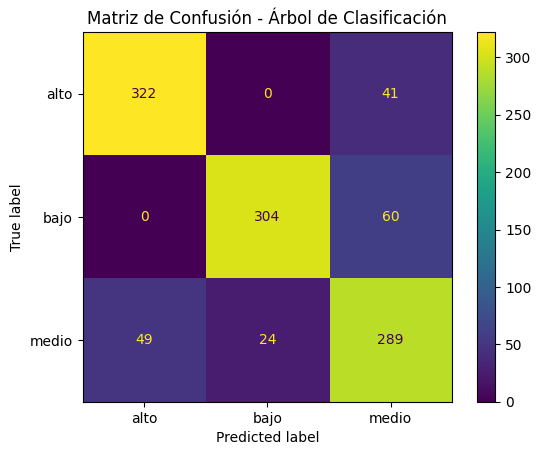

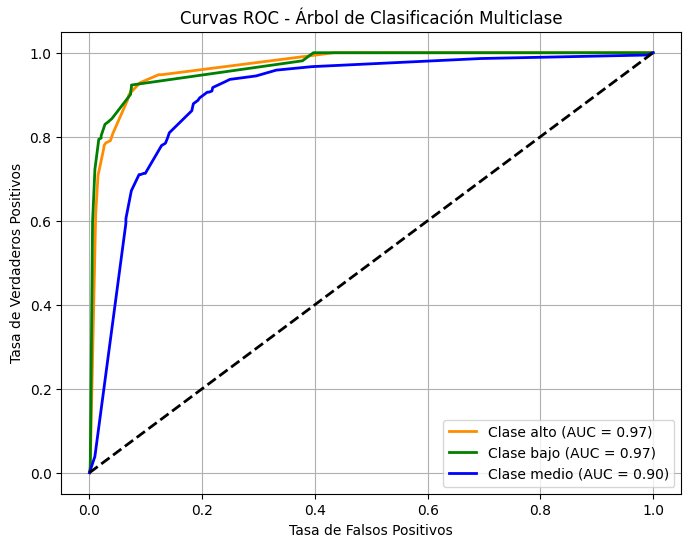

In [2]:
load_dotenv()

# Cargar el dataset
df = pd.read_csv(os.getenv("TRANSFORM_DATA_PATH"), sep=";")

# Crear variable objetivo: rendimiento multiclase (bajo, medio, alto) según la valoración
df["nivel_rendimiento"] = pd.qcut(df["Valoracion"], q=3, labels=["bajo", "medio", "alto"])
le = LabelEncoder()
df["clase_rendimiento"] = le.fit_transform(df["nivel_rendimiento"])  # 0: bajo, 1: medio, 2: alto

# Variables predictoras
features = [
    "Minutos", "Puntos", "Rebotes", "Asistencias", "Robos",
    "Perdidas", "Faltas Cometidas", "Faltas Recibidas",
    "Eficiencia Ofensiva", "Eficiencia Defensiva"
]

X = df[features]
y = df["clase_rendimiento"]

# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Binarización para curvas ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Pipeline: imputación + árbol
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("clf", DecisionTreeClassifier(max_depth=5, random_state=42))
])

# Entrenar
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

# Evaluación
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=le.classes_)
plt.title("Matriz de Confusión - Árbol de Clasificación")
plt.show()

# Curvas ROC
y_score = pipeline.named_steps["clf"].predict_proba(pipeline.named_steps["imputer"].transform(X_test))

plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'Clase {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC - Árbol de Clasificación Multiclase')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()